<a href="https://colab.research.google.com/github/alwaysneedhelp/AI-Challenge/blob/main/advertisement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Importing Necessary Libraries***

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from google.colab import drive
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import torch
import random
import zipfile
import os
from sklearn.model_selection import train_test_split
from PIL import Image
import torchvision.models as models
import torchvision.transforms as T
import torch.optim as optim
from sklearn.metrics import f1_score
from collections import Counter
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ***Loading Training Data***

## ***Extracting needed files from google drive***

In [110]:
# Fetch the train.csv from mydrive to local colab, so it is easier to work with it

if not (os.path.isfile('train.csv')):
  !cp '/content/drive/MyDrive/AI_Challenge_advertisement_train.csv' train.csv

df = pd.read_csv('train.csv')

In [111]:
# Extract all the images from drive to my folder

if not (os.path.exists('./images')):
  !cp '/content/drive/MyDrive/images.zip' . # Using cp extract the file from google drive to a local folder
  with zipfile.ZipFile('images.zip', 'r') as f:
    f.extractall('./images')

## ***Analyzing Data***

### ***Class Imbalance***

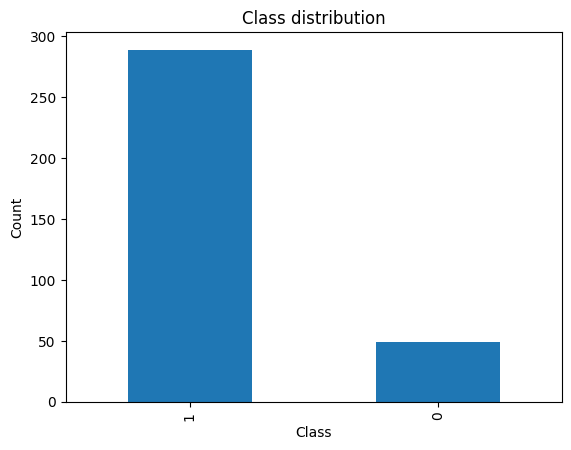

In [112]:
class_counts = df['class'].value_counts()

# plot
class_counts.plot(kind='bar')
plt.title("Class distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


### ***Image Resolutions (Matters very much for choosing the backbone)***

In [113]:
resolutions = [Image.open(f'images/{x}').size for x in df['image']]

print("Most common resolutions:")
print(Counter(resolutions).most_common(10))

Most common resolutions:
[((1200, 1600), 144), ((1875, 2500), 80), ((3024, 4032), 49), ((780, 1040), 27), ((720, 1280), 17), ((899, 1599), 8), ((901, 1600), 8), ((1875, 1406), 4), ((706, 727), 1)]


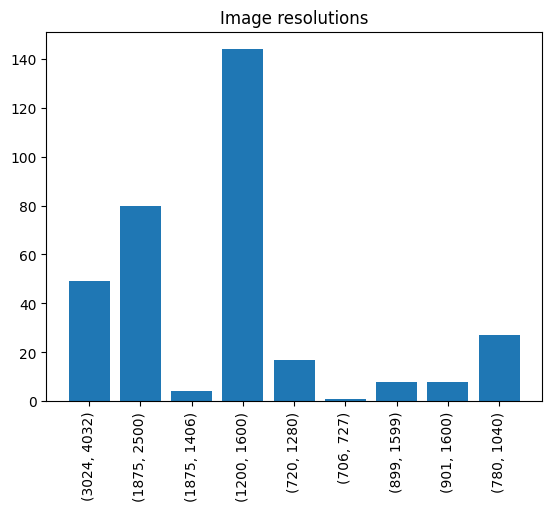

In [114]:
res_counts = Counter(resolutions)
plt.bar([str(k) for k in res_counts.keys()], res_counts.values())
plt.xticks(rotation=90)
plt.title("Image resolutions")
plt.show()


## ***Making sure the Results are Reproducible***

In [115]:
# Make the results reproducible using seed

SEED = 42
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(SEED)
random.seed(SEED)

## ***Splitting Data and Preparing the Augmentetion***

In [116]:
# Taking some part of the data for validation, as we don't necessarily need it
# (Since there is a lot of training data)

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state = SEED,
    stratify = df['class']
)

In [117]:
train_transform = T.Compose([
    T.Resize((256, 256)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(5),
    T.RandomResizedCrop(224, scale=(0.8, 1.0)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

## ***Creating Dataset***

In [118]:
class Img_Dataset(Dataset):
  def __init__(self, df, transform=None, img_dir='./images', labels=True):
    self.file_names = df['image'].tolist()
    self.img_dir = img_dir
    self.transform = transform
    self.labels = False

    # Just to not create a separate class for test
    # Adding extra-check if labels exist in the given df

    if labels:
      self.labels = df['class'].tolist()

  def __len__(self):
    return len(self.file_names)

  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.file_names[idx])
    image = Image.open(img_path).convert('RGB')


    if self.transform:
      image = self.transform(image)

    if self.labels:
      label = self.labels[idx]
      return image, label, self.file_names[idx]

    return image, self.file_names[idx]

In [119]:
train_dataset = Img_Dataset(
    train_df,
    transform = train_transform
    )
val_dataset = Img_Dataset(
    val_df,
    transform = val_transform
    )

## ***Load Data from Dataset***

In [120]:
# Creating a loder to load all the data

# Trying different batches starting off with 8, since we have a lot of data, but still the dataset isn't that large

BATCH = 8



# Add sample weights and weigthedrandomsampler to distribute data evenly
class_counts = train_df['class'].value_counts().to_dict()  # {0: n0, 1: n1}

# assign weight = 1/freq for each sample
sample_weights = train_df['class'].map(lambda y: 1.0 / class_counts[y]).values
sample_weights = sample_weights.astype(np.float32)

# build the sampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),   # draw as many samples as dataset size
    replacement=True                   # allow resampling
)


train_loader = DataLoader(
    train_dataset,
    batch_size = BATCH,
    num_workers = 2, # Put 2 workers, so that process goes faster
    drop_last = True, # Drop everything that remains after placing data into batches of 8
    sampler = sampler
)

val_loader = DataLoader(
    val_dataset,
    batch_size = BATCH,
    shuffle = False,
    num_workers = 2,
    drop_last = False
)

# ***Train the Model***

## ***Use Pretrained ResNet50 Model as BackBone***

In [121]:
def prepare_model():

    # Load a pretrained ResNet50 backbone
    m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

    # Getting how many features were input for the lasat layer
    in_features = m.fc.in_features

    # Replace the 1000-class head with a single-logit head
    m.fc = nn.Linear(in_features, 1)
    return m


model = prepare_model()

## ***Preparing Everything Needed for Training***

In [122]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha  # e.g., alpha = n_neg/(n_pos+n_neg) or 0.75

    def forward(self, logits, targets):
        # logits: [B,1], targets: [B,1] float in {0,1}
        bce = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        p = torch.sigmoid(logits)
        pt = p*targets + (1-p)*(1-targets)     # pt = p if y=1 else 1-p
        mod = (1 - pt).pow(self.gamma)         # focusing term
        if self.alpha is not None:
            alpha_t = self.alpha*targets + (1-self.alpha)*(1-targets)
            bce = alpha_t * bce
        return (mod * bce).mean()

In [123]:

# Making balanced loss function, since there is class imbalance in the dataset
n_pos = (train_df['class'] == 1).sum()
n_neg = (train_df['class'] == 0).sum()


# Try to use not just simple BCEWithLogitsLoss, but Focal Loss
# Since there is severe imbalance in classes
alpha = n_neg / (n_pos + n_neg)
criterion = FocalLoss(gamma=2.0, alpha=alpha)



# Use the common, simple Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Use scheduler to regulate lr
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

# Use scaler to reduce the memory usage
scaler = torch.amp.GradScaler(DEVICE)

In [124]:
def train(model, train_loader, val_loader, optimizer, scaler, epochs):
    model.to(DEVICE)

    best_val_f1 = -1.0
    best_threshold = 0.5

    for epoch in range(epochs):
        print(f'Epoch {epoch+1}')

        # ---- TRAIN ----
        model.train()
        running_loss = 0.0
        correct = 0.0
        all_preds = []
        all_labels = []

        for imgs, labels, _ in train_loader:
            labels = labels.to(DEVICE).float().unsqueeze(1)  # Add unsqueeze(1) here

            with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
                outputs = model(imgs)
                loss = criterion(outputs, labels)

            optimizer.zero_grad()
            if DEVICE == "cuda":
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

            running_loss += loss.item()

            # Train metrics @ fixed 0.5 (just for logging)
            preds = (torch.sigmoid(outputs) > 0.5).int()
            correct += (preds == labels.int()).sum().item()
            all_preds.extend(preds.view(-1).cpu().numpy().tolist())
            all_labels.extend(labels.view(-1).cpu().numpy().astype(int).tolist())

        running_loss /= len(train_loader)
        train_acc = 100.0 * correct / len(train_loader.dataset)
        train_f1 = f1_score(all_labels, all_preds, average='binary')

        print(f'Training Loss: {running_loss:.4f}')
        print(f'Training Accuracy: {train_acc:.2f}%')
        print(f'Training F1 @0.5: {train_f1:.4f}')

        # Validating at the same time while training
        model.eval()
        with torch.no_grad():
            val_probs = []
            val_labels = []
            for imgs, labels, _ in val_loader:
                imgs = imgs.to(DEVICE)
                logits = model(imgs)
                probs = torch.sigmoid(logits).squeeze(1).cpu().numpy()
                val_probs.extend(probs.tolist())
                val_labels.extend(labels.cpu().numpy().tolist())

        val_probs = np.array(val_probs)
        val_labels = np.array(val_labels)

        # Try different thresholds to maximize F1 score
        best_t_epoch = 0.5
        best_f1_epoch = 0.0
        for t in np.linspace(0.05, 0.95, 19):
            preds = (val_probs >= t).astype(int)
            f1 = f1_score(val_labels, preds, average='binary')
            if f1 > best_f1_epoch:
                best_f1_epoch = f1
                best_t_epoch = t

        print(f'Validation F1 (best): {best_f1_epoch:.4f} @ threshold {best_t_epoch:.2f}')

        # keep the best across epochs
        if best_f1_epoch > best_val_f1:
            best_val_f1 = best_f1_epoch
            best_threshold = best_t_epoch


    print(f'Best Val F1 over training: {best_val_f1:.4f} @ threshold {best_threshold:.2f}')
    return model, best_threshold, best_val_f1

## ***Training***

In [102]:
model, best_t, best_val_f1 = train(
    model,
    train_loader,
    val_loader,
    optimizer,
    scaler,
    3
)

Epoch 1


/tmp/ipython-input-3049905472.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Training Loss: 0.0122
Training Accuracy: 89.26%
Training F1 @0.5: 0.9030
Validation F1 (best): 0.9915 @ threshold 0.10
Epoch 2


/tmp/ipython-input-3049905472.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Training Loss: 0.0099
Training Accuracy: 92.22%
Training F1 @0.5: 0.9393
Validation F1 (best): 0.9748 @ threshold 0.05
Epoch 3


/tmp/ipython-input-3049905472.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Training Loss: 0.0387
Training Accuracy: 88.15%
Training F1 @0.5: 0.8839
Validation F1 (best): 0.9739 @ threshold 0.45
Best Val F1 over training: 0.9915 @ threshold 0.10


Solid results on training

# ***Save This Model***

In [103]:
if not (os.path.isfile('model.pth')):
  torch.save(model.state_dict(), 'model.pth')

# ***Now, Predict the Results for Test Data***

## ***Extract Files from GoogleDrive first***

In [104]:
# Fetch the test.csv from mydrive to local colab, so it is easier to work with it

if not (os.path.isfile('test.csv')):
  !cp '/content/drive/MyDrive/AI_Challenge_advertisement_test.csv' test.csv

test_df = pd.read_csv('test.csv')

## ***Load the Data***

In [105]:
test_dataset = Img_Dataset(
    test_df,
    val_transform,
    labels = False
)

In [106]:
test_loader = DataLoader(
    test_dataset,
    batch_size = BATCH,
    num_workers = 2,
    shuffle = False
)

## ***Predict***

In [107]:
# Create and store all the predictions

all_probs, all_names = [], []
model.eval()
if len(test_loader) == 0:
    print("Test loader is empty. No predictions will be made.")
else:
    with torch.no_grad():
        for imgs, names in test_loader:
            imgs = imgs.to(DEVICE)
            outputs = model(imgs)
            probs = torch.sigmoid(outputs).squeeze(1).cpu().numpy()
            all_probs.extend(probs)
            all_names.extend(names)

In [108]:
# Gathering all of them, and writing them in a right format

# Check if all_probs is empty before concatenating
if not all_probs:
    preds = np.array([])
else:
    preds = [int(prob>= best_t) for prob in all_probs]  # use best threshold


solution = pd.DataFrame({
    "image": all_names,
    "class": preds
})

# # Make sure solution order matches the test.csv
# solution = test_df[["image"]].merge(solution, on="image", how="left")
# solution["class"] = solution["class"].fillna(0).astype(int)

solution.to_csv("solution.csv", index=False)
print("Saved solution.csv")

Saved solution.csv
